In [1]:
import networkx as nx
import numpy as np
import pickle

from sklearn.metrics import roc_auc_score
from scipy.special import logsumexp
from XGraph import *
from XBeliefProgation import *

In [2]:
with open('SpEagle_edges_1.object', 'rb') as model_file:
    e = pickle.load(model_file)
    model_file.close()

In [3]:
with open('SpEagle_nodes_1.object', 'rb') as model_file:
    n = pickle.load(model_file)
    model_file.close()

In [4]:
with open('SpEagle_potentials_1.object', 'rb') as model_file:
    p = pickle.load(model_file)
    model_file.close()

## 1. Init BP

In [5]:
bp = BeliefPropagation(n, e, p, max_iters = 10)

In [6]:
bp.standard_bp()

1-th times
difference in messages: 4.995082
2-th times
difference in messages: 5.514984
3-th times
difference in messages: 0.581881
4-th times
difference in messages: 0.000033
BP has converged.


In [7]:
bp.init_ad_bp()

Begining Euler_tour...
Euler_tour finished
Begining RMQ
Init adaptive BP finished


In [8]:
bp.save_model()

Model has been saved as bp_model.object


## 2. Verify

In [13]:
predict = bp.classify()

In [14]:
organic_predictions = {}
for k,v in predict.items():
    if isinstance(k, tuple):
        # remove the prefixes
        u_id = k[0][1:]
        p_id = k[1][1:]
        
        organic_predictions[(u_id, p_id)] = v
    if isinstance(k, str) == 1 and k[0] == 'u':
        u_id = k[1:]
        organic_predictions[u_id] = v

In [15]:
with open('SpEagle_ground_truth_1.object', 'rb') as model_file:
    ground_truth = pickle.load(model_file)
    model_file.close()

In [16]:
print('Use SpEagle without labeled data:')
#user_auc, review_auc = evaluate(ground_truth, organic_predictions)
auc_speagle = evaluate(ground_truth, organic_predictions)
user_auc = auc_speagle
review_auc = auc_speagle
print('User AUC = %f\t\t\tReview AUC = %f' % (user_auc, review_auc))
print('\n--------\n')
print('\a')

Use SpEagle without labeled data:
User AUC = 0.733278			Review AUC = 0.733278

--------




In [17]:
w1 = 'u437'
wv1 = 0.999
w2 = 'u451'
wv2 = 0.999
v = 'p8'

## 3. Adaptive BP

In [18]:
with open('bp_model.object', 'rb') as model_file:
    abp = pickle.load(model_file)
    model_file.close()

In [19]:
abp.modify_node(w1, wv1)

In [20]:
abp.modify_node(w2, wv2)

In [49]:
abp.interest_node(v)

array([ -3.11219893, -32.10207694])

## 4. Standard BP

In [22]:
with open('bp_model.object', 'rb') as model_file:
    sbp = pickle.load(model_file)
    model_file.close()

In [23]:
sbp.nodes.n_dict[w1]['prior'] = wv1
sbp.nodes.n_dict[w2]['prior'] = wv2

In [24]:
sbp.standard_bp()

1-th times
difference in messages: 0.000044
BP has converged.


In [25]:
belief, _ = sbp.get_belief(v)
belief

array([ -2.87970983, -32.75903478])

In [26]:
with open('bp_model.object', 'rb') as model_file:
    obp = pickle.load(model_file)
    model_file.close()

In [27]:
belief, _ = obp.get_belief(v)
belief

array([ -2.87860035, -32.76893606])

## 5. No shortest path

In [30]:
with open('bp_model.object', 'rb') as model_file:
    nbp = pickle.load(model_file)
    model_file.close()

In [31]:
nbp.LCA('u201','p5')

Cannot find the path between u201 and p5


In [32]:
nbp.LCA('u202', 'p5')

Cannot find the path between u202 and p5


In [33]:
nbp.modify_node('u201', 0.999)
nbp.modify_node('p5', 0.001)

In [50]:
belief, _ = nbp.interest_node('u202')
belief

Cannot find the path between u201 and p5
Cannot find the path between p5 and u202
Cannot find any path between modified node and visible node


array([-0.08255866, -7.21360717])

In [35]:
with open('bp_model.object', 'rb') as model_file:
    sbbp = pickle.load(model_file)
    model_file.close()

In [51]:
belief, _ = sbbp.get_belief('u202')
belief

array([-0.08255866, -7.21360717])

In [52]:
sbbp.nodes.n_dict['u201']['prior'] = 0.999
sbbp.nodes.n_dict['p5']['prior'] = 0.001

In [53]:
sbbp.standard_bp()

1-th times
difference in messages: 0.000008
BP has converged.


In [54]:
belief, _ = sbbp.get_belief('u202')
belief

array([-0.08255866, -7.21360717])

## 6. Unit Test

#### 1) Create Graph

In [46]:
G1 = BP_Generator('s')
G2 = BP_Generator('m')
G3 = BP_Generator('l')

#### 2) 

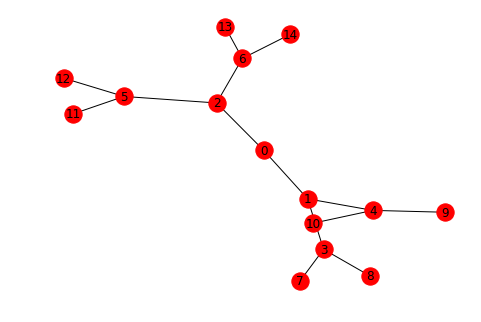

In [47]:
G1.graph.show_graph(with_labels=True)

In [48]:
graph_list = ['G1', 'G2', 'G3']
init_unit_test(graph_list)

NameError: name 'G1' is not defined

In [114]:
model_list = ['G1.object', 'G2.object', 'G3.object']

In [115]:
def do_unit_test(model_list):
    res = {}
    for m in model_list:
        result = {}
        with open(m, 'rb') as model_file:
            bp = pickle.load(model_file)
            model_file.close()
        all_nodes = bp.graph.Node.n_dict
        w_seq, v_seq, w_value = wv_sequence(all_nodes)
        # Original Belief
        ori_belief = []
        for v in range(1,len(v_seq)):
            belief, _ = bp.get_belief(v_seq[v])
            ori_belief.append(belief)
        # standard BP
        with open(m, 'rb') as model_file:
            sbp = pickle.load(model_file)
            model_file.close()
        standard_belief = []
        for w in range(1,len(w_seq)):
            sbp.nodes.n_dict[w_seq[w-1]]['prior'] = w_value[w-1]
            sbp.nodes.n_dict[w_seq[w]]['prior'] = w_value[w]
            sbp.standard_bp(show_result=False)
            belief, _ = sbp.get_belief(v_seq[w])
            standard_belief.append(belief)
        # adaptive BP
        with open(m, 'rb') as model_file:
            abp = pickle.load(model_file)
            model_file.close()
        adaptive_belief = []
        for w in range(1,len(w_seq)):
            abp.modify_node(w_seq[w-1], w_value[w-1])
            abp.modify_node(w_seq[w], w_value[w])
            belief = abp.interest_node(v_seq[w])
            adaptive_belief.append(belief)
        result['ori_belief'] = ori_belief
        result['standard_belief'] = standard_belief
        result['adaptive_belief'] = adaptive_belief
        result['o_s_diff'] = np.sum(np.abs(np.subtract(ori_belief, standard_belief)))
        result['o_a_diff'] = np.sum(np.abs(np.subtract(ori_belief, adaptive_belief)))
        result['s_a_diff'] = np.sum(np.abs(np.subtract(standard_belief, adaptive_belief)))
        res[str(m)] = result

    return res

In [116]:
def wv_sequence(all_nodes, node_per=0.02):
    w_seq = []
    v_seq = []
    node_num = 10
    node_list = list(all_nodes.keys())
    for i in range(node_num):
        choice_node = np.random.choice(node_list)
        node_list.remove(choice_node)
        w_seq.append(choice_node)
    
    node_list = list(all_nodes.keys())
    for i in range(node_num):
        choice_node = np.random.choice(node_list)
        node_list.remove(choice_node)
        v_seq.append(choice_node)
    v = np.random.random(len(w_seq))
    w_value = np.transpose(np.tile(v,(2,1)))
    w_value[:,1] = 1- w_value[:,1]
    w_value = np.log(w_value)
    return w_seq, v_seq, w_value
    

In [117]:
res = do_unit_test(model_list) # tol = 1e-3

In [118]:
res

{'G1.object': {'ori_belief': [array([-5.9174244 , -2.35918955]),
   array([-1.11657795, -1.78133669]),
   array([-1.11356288, -1.84951215]),
   array([-0.75629188, -2.31579097]),
   array([-0.82956212, -2.18554535]),
   array([-1.47183444, -1.63241796]),
   array([-2.22470002, -4.41866967]),
   array([-2.11449866, -4.90134191]),
   array([-2.67007795, -3.57701313])],
  'standard_belief': [array([-5.97440355, -2.23850288]),
   array([-0.89062199, -2.05763301]),
   array([-1.17404666, -1.71777332]),
   array([-0.98596268, -1.91987618]),
   array([-0.94036827, -1.96153017]),
   array([-1.51523674, -1.53281305]),
   array([-2.49373476, -3.48955275]),
   array([-2.33839603, -4.12083012]),
   array([-1.75635012, -6.91884007])],
  'adaptive_belief': [array([-5.97440355, -2.23850288]),
   array([-0.89062199, -2.05763301]),
   array([-1.17404666, -1.71777332]),
   array([-0.98596268, -1.91987618]),
   array([-0.94036827, -1.96153017]),
   array([-1.51523674, -1.53281305]),
   array([-2.49373476

In [107]:
res1 = do_unit_test(model_list) # tol = 1e-5

In [108]:
res1

{'G1.object': {'ori_belief': [array([-2.06717293, -1.02206467]),
   array([-3.62907804, -3.16102504]),
   array([-3.19441716, -2.93305932]),
   array([-2.13215253, -3.6325153 ]),
   array([-0.81386853, -2.23043979]),
   array([-3.00548363, -0.91546885]),
   array([-2.44499831, -3.64632117]),
   array([-0.85423607, -2.12730805]),
   array([-0.80611628, -2.3586096 ])],
  'standard_belief': [array([-2.06753564, -1.02166198]),
   array([-3.62995618, -3.15872502]),
   array([-3.19502405, -2.93256312]),
   array([-2.12480602, -3.68079468]),
   array([-0.98633142, -2.23372607]),
   array([-3.5560063 , -0.48316355]),
   array([-2.21284325, -3.82266327]),
   array([-1.08267536, -1.83957705]),
   array([-0.91935621, -2.3805789 ])],
  'adaptive_belief': [array([-2.06753564, -1.02166198]),
   array([-3.62995618, -3.15872502]),
   array([-3.19502405, -2.93256312]),
   array([-2.12480602, -3.68079468]),
   array([-0.98633142, -2.23372607]),
   array([-3.5560063 , -0.48316355]),
   array([-2.21284325

In [87]:
def set_new_prior(prior):
    p = 1 - prior
    pr = np.array(np.log([prior, p]))
    return pr

In [51]:
with open('G3.object', 'rb') as model_file:
    bp3 = pickle.load(model_file)
    model_file.close()

In [52]:
w_seq, v_seq, w_value = wv_sequence(bp3.graph.Node.n_dict)

In [53]:
with open('G2.object', 'rb') as model_file:
    bp = pickle.load(model_file)
    model_file.close()

In [54]:
with open('G2.object', 'rb') as model_file:
    sbp = pickle.load(model_file)
    model_file.close()

In [55]:
with open('G2.object', 'rb') as model_file:
    abp = pickle.load(model_file)
    model_file.close()

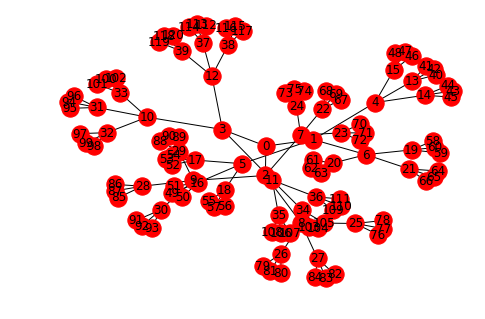

In [56]:
sbp.graph.show_graph(with_labels=True)

In [57]:
pri1 = set_new_prior(0.9)
pri2 = set_new_prior(0.9)

In [58]:
sbp.nodes.n_dict[27]['prior'] = pri1

In [59]:
sbp.nodes.n_dict[91]['prior'] = pri2

In [60]:
sbp.standard_bp(show_result=False)

In [61]:
belief, _ = sbp.get_belief(8)
belief

array([-4.32563735, -3.76152073])

In [62]:
abp.modify_node(27, pri1)

In [63]:
abp.modify_node(91, pri2)

In [64]:
abp.interest_node(8)

array([-4.32515229, -3.76195149])

In [65]:
bp.nodes.n_dict[8]['prior']

array([-2.08672141, -0.13249572])

In [66]:
belief, _ = bp.get_belief(8)
belief

array([-4.33292983, -3.74856721])

In [67]:
def adaptive_bp(w1, p1, w2, p2, v, model_name='G2.object', with_labels=True):
    with open(model_name, 'rb') as model_file:
        bp = pickle.load(model_file)
        model_file.close()
    with open(model_name, 'rb') as model_file:
        sbp = pickle.load(model_file)
        model_file.close()
    with open(model_name, 'rb') as model_file:
        abp = pickle.load(model_file)
        model_file.close()
    sbp.graph.show_graph(with_labels=with_labels)
    
    result = {}
    # Setting Prior
    pri1 = set_new_prior(p1)
    pri2 = set_new_prior(p2)
    
    # Standard Belief Propagation
    sbp.nodes.n_dict[w1]['prior'] = pri1
    sbp.nodes.n_dict[w2]['prior'] = pri2
    sbp.standard_bp(show_result=False)
    belief, _ = sbp.get_belief(v)
    result['Standard_BP'] = belief
    
    # Adaptive Belief Propagation
    abp.modify_node(w1, pri1)
    abp.modify_node(w2, pri2)
    res_a = abp.interest_node(v)
    result['Adaptive_BP'] = res_a
    
    ori_b, _ = bp.get_belief(v)
    # Original belief
    result['Original_belief'] = ori_b
    
    return result